Задача №2
Исполнитель: Филатов Андрей


Сравнить стратегии Probability of Improvement, Expected Improvement, GP Upper Confidence Bound для оптимизации гиперпараметров гауссовым процессом. Визуализировать, аналогично рисункам 1.a,1.b,1.c из статьи. Проинтерпретировать полученные результаты

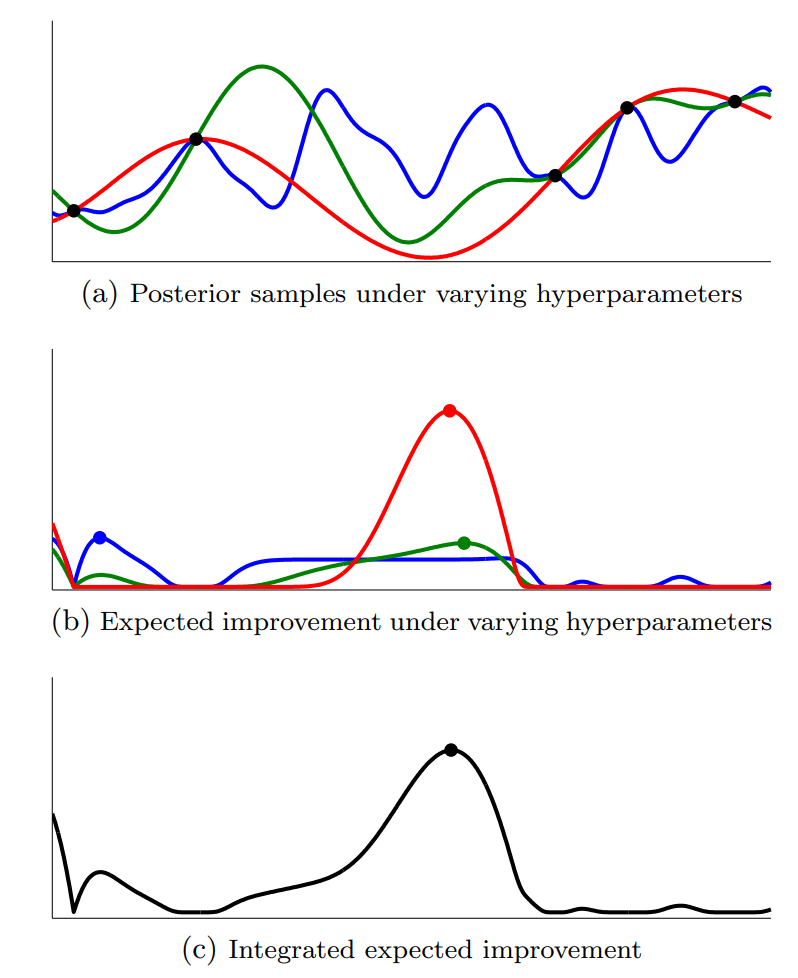

### Imports

In [5]:
!pip install -q gpytorch
!pip install -q botorch

     |████████████████████████████████| 347 kB 5.5 MB/s 


In [2]:
import torch
import torch.nn as nn
import tqdm
import numpy as np
import gpytorch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

To check different acquisition functions we will use the following setup.

`Dataset`: CIFAR-10

`Model`: Simple CNN

`Optimized function`: Validation loss after one epoch

In [3]:
data_train = datasets.CIFAR10('/content', download=True, transform=transforms.ToTensor())
data_val = datasets.CIFAR10('/content', download=True, transform=transforms.ToTensor(), train=False)
dataloader = DataLoader(data_train, batch_size=32, num_workers=2)
val_dataloader = DataLoader(data_val, batch_size=32, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4*4*128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

Training

In [53]:
train_model = Model().cuda()
criterion = nn.CrossEntropyLoss()

In [56]:
res = []
for lr in tqdm.tqdm(np.logspace(-1, -5)):
    optim = torch.optim.SGD(train_model.parameters(), lr=lr)
    for batch in dataloader:
        optim.zero_grad()
        x, y = map(lambda x: x.cuda(), batch)
        y_pred = train_model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optim.step() 

    val_loss = 0.0
    with torch.no_grad():
        for val_batch in val_dataloader:
            x, y = map(lambda x: x.cuda(), val_batch)
            y_pred = train_model(x)
            val_loss += criterion(y_pred, y)

    res.append(val_loss.detach().item())

100%|██████████| 50/50 [09:47<00:00, 11.75s/it]


Preprocessing our loss values. Otherwise, the we are unable to fit Gaussian process as we have the big variance

In [28]:
x_train = torch.linspace(-1, -5, 50)
# y_train = torch.tensor(res)
y_train = torch.tensor(np.load('/content/arr.npy'), dtype=torch.float32)
y_train /= y_train.max()
y_train -= y_train.mean()

Creating Gaussian process model

In [29]:
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils.containers import TrainingData
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP


class SimpleCustomGP(ExactGP, GPyTorchModel):

    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y, likelihood):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    @classmethod
    def construct_inputs(cls, training_data: TrainingData, **kwargs):
        r"""Construct kwargs for the `SimpleCustomGP` from `TrainingData` and other options.

        Args:
            training_data: `TrainingData` container with data for single outcome
                or for multiple outcomes for batched multi-output case.
            **kwargs: None expected for this class.
        """
        return {"train_X": training_data.X, "train_Y": training_data.Y}

In [30]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SimpleCustomGP(x_train.reshape(-1, 1), y_train.reshape(-1, 1), likelihood)

Fitting GP model

In [32]:
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(500):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    if i % 50 == 0:

        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, 10000, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

Iter 1/10000 - Loss: 0.852   lengthscale: 0.693   noise: 0.693
Iter 51/10000 - Loss: -1.608   lengthscale: 3.556   noise: 0.005
Iter 101/10000 - Loss: -3.060   lengthscale: 3.234   noise: 0.000
Iter 151/10000 - Loss: -3.271   lengthscale: 0.835   noise: 0.000
Iter 201/10000 - Loss: -3.302   lengthscale: 0.745   noise: 0.000
Iter 251/10000 - Loss: -3.312   lengthscale: 0.758   noise: 0.000
Iter 301/10000 - Loss: -3.317   lengthscale: 0.767   noise: 0.000
Iter 351/10000 - Loss: -3.319   lengthscale: 0.773   noise: 0.000
Iter 401/10000 - Loss: -3.321   lengthscale: 0.761   noise: 0.000
Iter 451/10000 - Loss: -3.323   lengthscale: 0.767   noise: 0.000


Getting GP prediction

In [33]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, -6, 50)
    observed_pred = likelihood(model(test_x))

Visualization of GP samples

/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:161: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:161: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:161: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


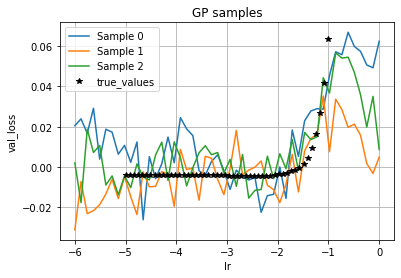

In [91]:
for i in range(3):
    plt.plot(test_x, observed_pred.sample_n(1)[0], label=f'Sample {i}')
    
plt.plot(x_train, y_train, 'k*', label='true_values')
plt.legend()
plt.title('GP samples')
plt.xlabel('lr')
plt.ylabel('val_loss')
plt.grid()
plt.show()

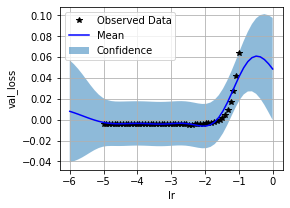

In [93]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)

    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.grid()
    plt.xlabel('lr')
    plt.ylabel('val_loss')
    plt.show()

## Plotting acquisition functions

In [94]:
from botorch.acquisition.analytic import UpperConfidenceBound, ExpectedImprovement, ProbabilityOfImprovement

In [95]:
tmp = test_x.reshape(-1, 1).unsqueeze(-1)

In [96]:
UCB = UpperConfidenceBound(model, beta=0.2, maximize=False)
ucb = UCB(tmp)

EI = ExpectedImprovement(model, best_f=0.2, maximize=False)
ei = EI(tmp)

PI = ProbabilityOfImprovement(model, best_f=0.2, maximize=False)
pi = PI(tmp)

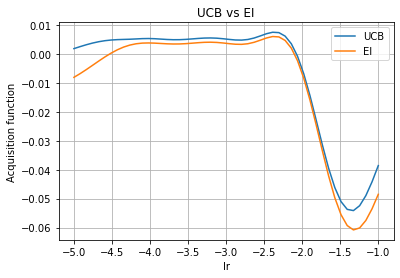

In [107]:
plt.plot(x_train.detach().numpy(), ucb.detach().numpy(), label='UCB')
plt.plot(x_train.detach().numpy(), ei.detach().numpy() - 0.2, label='EI')


plt.title('UCB vs EI')
plt.xlabel('lr')
plt.ylabel('Acquisition function')
plt.legend()
plt.grid()
plt.show()

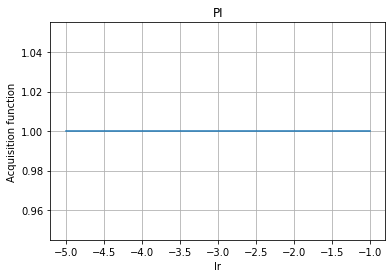

In [109]:
plt.plot(x_train.detach().numpy(), pi.detach().numpy())

plt.title('PI')
plt.xlabel('lr')
plt.ylabel('Acquisition function')
plt.grid()
plt.show()

## Анализ

Первое замечание: нужно уделить внимание гиперпараметра методов оптимизации. То есть порог 0.2, выбранный для PI, не работае, так как лосс находится в границах [-0.1, 0.1]. Поэтому решением будет привести данные к стандартному виду либо адаптивно подбирать порог

Второе замечания: методы UCB и EI не сильно отличаются. EI немного сложнее вычислять, но других отличий я не заметил.